In [1]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import seaborn as sns
import pickle
import math

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 700)

This notebook analyzes the Gelderman SOD cohort (data that was labeled for SOD classification /home/anau/SOD_labeling/Gelderman) in order to create a strong dataset for PMI estimation. 

# Import master dataset

In [2]:
master_data = pd.read_pickle('../data/master_dataset.pkl')
print(len(master_data))
display(master_data.head())

1132970


,new_id,old_id,img_path,img,correct_img_date,date_placed_ARF,PMI_days,year,sex,ancestry,est_stature_cm,est_weight_lb,est_stature_in,age_at_death,true_BP,pred_BP,pred_BP_conf,true_SOD_G,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M
0,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000121.01.JPG,00000121.01.JPG,2018-01-21,2018-01-21,0.0,2018.0,Male,NaN,177.8,160.0,70.000038,64.0,NaN,stake,100.00,NaN,NaN,NaN,NaN,NaN,NaN
1,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000121.02.JPG,00000121.02.JPG,2018-01-21,2018-01-21,0.0,2018.0,Male,NaN,177.8,160.0,70.000038,64.0,NaN,fullbody,85.51,NaN,NaN,NaN,NaN,NaN,NaN
2,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000121.03.JPG,00000121.03.JPG,2018-01-21,2018-01-21,0.0,2018.0,Male,NaN,177.8,160.0,70.000038,64.0,NaN,fullbody,90.52,NaN,NaN,NaN,NaN,NaN,NaN
3,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000121.04.JPG,00000121.04.JPG,2018-01-21,2018-01-21,0.0,2018.0,Male,NaN,177.8,160.0,70.000038,64.0,NaN,fullbody,99.50,NaN,NaN,NaN,NaN,NaN,NaN
4,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000121.05.JPG,00000121.05.JPG,2018-01-21,2018-01-21,0.0,2018.0,Male,NaN,177.8,160.0,70.000038,64.0,NaN,fullbody,43.47,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# drop columns not needed
master_data = master_data[['new_id', 'img', 'correct_img_date', 'date_placed_ARF', 'PMI_days', 'age_at_death',
                          'sex', 'est_weight_lb', 'est_stature_in', 'true_SOD_G', 'BP_of_true_SOD_G']].copy()
display(master_data.head())

,new_id,img,correct_img_date,date_placed_ARF,PMI_days,age_at_death,sex,est_weight_lb,est_stature_in,true_SOD_G,BP_of_true_SOD_G
0,000,00000121.01.JPG,2018-01-21,2018-01-21,0.0,64.0,Male,160.0,70.000038,NaN,NaN
1,000,00000121.02.JPG,2018-01-21,2018-01-21,0.0,64.0,Male,160.0,70.000038,NaN,NaN
2,000,00000121.03.JPG,2018-01-21,2018-01-21,0.0,64.0,Male,160.0,70.000038,NaN,NaN
3,000,00000121.04.JPG,2018-01-21,2018-01-21,0.0,64.0,Male,160.0,70.000038,NaN,NaN
4,000,00000121.05.JPG,2018-01-21,2018-01-21,0.0,64.0,Male,160.0,70.000038,NaN,NaN


In [4]:
# extract donor_date from img column
master_data['donor_date'] = master_data.img.str.split('.', expand=True)[0]
display(master_data.head(3))

,new_id,img,correct_img_date,date_placed_ARF,PMI_days,age_at_death,sex,est_weight_lb,est_stature_in,true_SOD_G,BP_of_true_SOD_G,donor_date
0,000,00000121.01.JPG,2018-01-21,2018-01-21,0.0,64.0,Male,160.0,70.000038,NaN,NaN,00000121
1,000,00000121.02.JPG,2018-01-21,2018-01-21,0.0,64.0,Male,160.0,70.000038,NaN,NaN,00000121
2,000,00000121.03.JPG,2018-01-21,2018-01-21,0.0,64.0,Male,160.0,70.000038,NaN,NaN,00000121


<class 'pandas.core.frame.DataFrame'>
Int64Index: 38156 entries, 0 to 1132967
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   new_id            38156 non-null  object 
 1   img               38156 non-null  object 
 2   correct_img_date  38156 non-null  object 
 3   date_placed_ARF   38156 non-null  object 
 4   PMI_days          38156 non-null  float64
 5   age_at_death      37855 non-null  float64
 6   sex               37829 non-null  object 
 7   est_weight_lb     35119 non-null  float64
 8   est_stature_in    36476 non-null  float64
 9   true_SOD_G        2 non-null      float64
 10  BP_of_true_SOD_G  2 non-null      object 
 11  donor_date        38156 non-null  object 
dtypes: float64(5), object(7)
memory usage: 3.8+ MB


None

,PMI_days,age_at_death,est_weight_lb,est_stature_in,true_SOD_G
count,38156.000000,37855.000000,35119.000000,36476.000000,2.0
mean,108.044187,66.486726,185.709106,65.316149,3.0
std,179.790425,14.681099,60.546338,12.001528,0.0
min,0.000000,18.000000,75.000000,0.000000,3.0
25%,21.000000,58.000000,145.000000,64.000000,3.0
50%,47.000000,68.000000,175.000000,67.000036,3.0
75%,101.000000,76.000000,212.000000,70.000038,3.0
max,2359.000000,98.000000,516.000000,80.000000,3.0


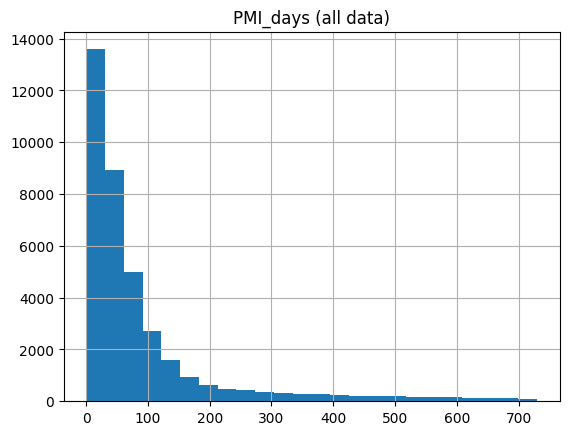

In [41]:
# PMI per donor_date analysis
pmi_per_donor_date = master_data.drop_duplicates(subset=['donor_date']).copy()
display(pmi_per_donor_date.info())
display(pmi_per_donor_date.describe())

pmi_per_donor_date[pmi_per_donor_date.PMI_days <= 730].hist(column='PMI_days', bins=24)
plt.title('PMI_days (all data)')
plt.show()

# Gelderman SOD cohort analysis

In [5]:
# extract Gelderman SOD cohort
g_data = master_data[master_data.true_SOD_G.notnull()].copy()
print(g_data.shape)
display(g_data.head())

g_data.to_csv('../data/Gelderman_SOD_cohort/all_labeled_imgs.csv', index=False)

(6055, 12)


,new_id,img,correct_img_date,date_placed_ARF,PMI_days,age_at_death,sex,est_weight_lb,est_stature_in,true_SOD_G,BP_of_true_SOD_G,donor_date
1992,004,00400124.07.JPG,2018-01-24,2018-01-09,15.0,77.0,Female,180.0,64.0,3.0,torso,00400124
1995,004,00400124.10.JPG,2018-01-24,2018-01-09,15.0,77.0,Female,180.0,64.0,3.0,legs,00400124
1996,004,00400124.11.JPG,2018-01-24,2018-01-09,15.0,77.0,Female,180.0,64.0,3.0,legs,00400124
1997,004,00400124.12.JPG,2018-01-24,2018-01-09,15.0,77.0,Female,180.0,64.0,3.0,head,00400124
1998,004,00400124.13.JPG,2018-01-24,2018-01-09,15.0,77.0,Female,180.0,64.0,3.0,head,00400124


In [6]:
g_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6055 entries, 1992 to 1132660
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   new_id            6055 non-null   object 
 1   img               6055 non-null   object 
 2   correct_img_date  6055 non-null   object 
 3   date_placed_ARF   6055 non-null   object 
 4   PMI_days          6055 non-null   float64
 5   age_at_death      6043 non-null   float64
 6   sex               6043 non-null   object 
 7   est_weight_lb     5609 non-null   float64
 8   est_stature_in    5789 non-null   float64
 9   true_SOD_G        6055 non-null   float64
 10  BP_of_true_SOD_G  6055 non-null   object 
 11  donor_date        6055 non-null   object 
dtypes: float64(5), object(7)
memory usage: 615.0+ KB


In [7]:
g_data.describe()

,PMI_days,age_at_death,est_weight_lb,est_stature_in,true_SOD_G
count,6055.000000,6043.000000,5609.000000,5789.000000,6055.000000
mean,47.942362,66.328314,184.224443,65.507804,3.505202
std,47.676456,14.211905,58.479428,9.759670,1.154242
min,0.000000,21.000000,95.000000,0.000000,1.000000
25%,14.000000,59.000000,144.000000,64.000000,3.000000
50%,34.000000,68.000000,174.000000,66.000036,3.000000
75%,71.000000,76.000000,210.000000,70.000038,4.000000
max,338.000000,96.000000,516.000000,77.000042,6.000000


### Align images by donor and date

In [8]:
# split into individual bodypart dataframes
head_df = g_data[g_data.BP_of_true_SOD_G == 'head'].copy()
torso_df = g_data[(g_data.BP_of_true_SOD_G == 'torso') | (g_data.BP_of_true_SOD_G == 'backside')].copy()
limbs_df = g_data[(g_data.BP_of_true_SOD_G == 'arm') | (g_data.BP_of_true_SOD_G == 'legs')].copy()
print(head_df.shape, torso_df.shape, limbs_df.shape)

(2041, 12) (1982, 12) (2032, 12)


In [9]:
# align dataframes on donor_date column
head_torso_aligned = pd.merge(head_df , torso_df[['donor_date', 'img','true_SOD_G']], 
                            how='inner', on='donor_date', suffixes= ('_head', '_torso'))
print(head_torso_aligned.shape)
display(head_torso_aligned.head())

head_torso_limbs_aligned = pd.merge(head_torso_aligned, limbs_df[['donor_date', 'img','true_SOD_G']], 
                                  how='inner', on='donor_date')
print(head_torso_limbs_aligned.shape)
head_torso_limbs_aligned.head()

(9735, 14)


,new_id,img_head,correct_img_date,date_placed_ARF,PMI_days,age_at_death,sex,est_weight_lb,est_stature_in,true_SOD_G_head,BP_of_true_SOD_G,donor_date,img_torso,true_SOD_G_torso
0,004,00400124.12.JPG,2018-01-24,2018-01-09,15.0,77.0,Female,180.0,64.0,3.0,head,00400124,00400124.07.JPG,3.0
1,004,00400124.12.JPG,2018-01-24,2018-01-09,15.0,77.0,Female,180.0,64.0,3.0,head,00400124,00400124.22.JPG,3.0
2,004,00400124.12.JPG,2018-01-24,2018-01-09,15.0,77.0,Female,180.0,64.0,3.0,head,00400124,00400124.23.JPG,3.0
3,004,00400124.12.JPG,2018-01-24,2018-01-09,15.0,77.0,Female,180.0,64.0,3.0,head,00400124,00400124.46.JPG,3.0
4,004,00400124.12.JPG,2018-01-24,2018-01-09,15.0,77.0,Female,180.0,64.0,3.0,head,00400124,00400124.47.JPG,3.0


(42080, 16)


,new_id,img_head,correct_img_date,date_placed_ARF,PMI_days,age_at_death,sex,est_weight_lb,est_stature_in,true_SOD_G_head,BP_of_true_SOD_G,donor_date,img_torso,true_SOD_G_torso,img,true_SOD_G
0,004,00400124.12.JPG,2018-01-24,2018-01-09,15.0,77.0,Female,180.0,64.0,3.0,head,00400124,00400124.07.JPG,3.0,00400124.10.JPG,3.0
1,004,00400124.12.JPG,2018-01-24,2018-01-09,15.0,77.0,Female,180.0,64.0,3.0,head,00400124,00400124.07.JPG,3.0,00400124.11.JPG,3.0
2,004,00400124.12.JPG,2018-01-24,2018-01-09,15.0,77.0,Female,180.0,64.0,3.0,head,00400124,00400124.07.JPG,3.0,00400124.18.JPG,4.0
3,004,00400124.12.JPG,2018-01-24,2018-01-09,15.0,77.0,Female,180.0,64.0,3.0,head,00400124,00400124.07.JPG,3.0,00400124.19.JPG,4.0
4,004,00400124.12.JPG,2018-01-24,2018-01-09,15.0,77.0,Female,180.0,64.0,3.0,head,00400124,00400124.07.JPG,3.0,00400124.36.JPG,3.0


In [10]:
# rename some columns
head_torso_limbs_aligned.rename(columns={"img": "img_limbs", "true_SOD_G": "true_SOD_G_limbs"}, inplace=True)

In [11]:
# number of unique image combinations (i.e., image triplets)
print(len(head_torso_limbs_aligned), len(head_torso_limbs_aligned[['img_head', 'img_torso', 'img_limbs']].drop_duplicates()))

42080 42080


In [64]:
# save image triplets to CSV file
head_torso_limbs_aligned.to_csv('../data/Gelderman_SOD_cohort/all_img_triplets.csv', index=False)

In [65]:
# keep only one image triplet per donor_date
unique_triplets = head_torso_limbs_aligned.drop_duplicates(subset=['donor_date']).copy()
display(unique_triplets.info())
display(unique_triplets.describe())

unique_triplets.to_csv('../data/Gelderman_SOD_cohort/unique_img_triplets.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174 entries, 0 to 41940
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   new_id            174 non-null    object 
 1   img_head          174 non-null    object 
 2   correct_img_date  174 non-null    object 
 3   date_placed_ARF   174 non-null    object 
 4   PMI_days          174 non-null    float64
 5   age_at_death      173 non-null    float64
 6   sex               173 non-null    object 
 7   est_weight_lb     162 non-null    float64
 8   est_stature_in    168 non-null    float64
 9   true_SOD_G_head   174 non-null    float64
 10  BP_of_true_SOD_G  174 non-null    object 
 11  donor_date        174 non-null    object 
 12  img_torso         174 non-null    object 
 13  true_SOD_G_torso  174 non-null    float64
 14  img_limbs         174 non-null    object 
 15  true_SOD_G_limbs  174 non-null    float64
dtypes: float64(7), object(9)
memory usage: 23.

None

,PMI_days,age_at_death,est_weight_lb,est_stature_in,true_SOD_G_head,true_SOD_G_torso,true_SOD_G_limbs
count,174.000000,173.000000,162.000000,168.000000,174.000000,174.000000,174.00000
mean,48.500000,65.676301,190.182099,65.085149,3.718391,3.442529,3.41954
std,50.536057,14.498170,66.457238,12.090674,1.270386,1.145298,1.07621
min,0.000000,30.000000,95.000000,0.000000,1.000000,1.000000,1.00000
25%,14.000000,57.000000,145.000000,64.000026,3.000000,3.000000,3.00000
50%,33.000000,67.000000,180.000000,66.550036,3.000000,3.000000,3.00000
75%,65.500000,76.000000,220.000000,70.000038,5.000000,4.000000,4.00000
max,338.000000,96.000000,516.000000,77.000042,6.000000,6.000000,6.00000


The unique_triplets data gives the number of samples the Gelderman PMI/ADD formulas can be applied to without duplicates. This data will now be used to apply Gelderman's PMI formula and then analyzed.

### Apply Gelderman's PMI formula to unique_triplets data

In [66]:
# calculate total decomposition score (TDS)
unique_triplets['TDS'] = unique_triplets['true_SOD_G_head']+unique_triplets['true_SOD_G_torso']+unique_triplets['true_SOD_G_limbs']
display(unique_triplets.head())
display(unique_triplets.describe())

,new_id,img_head,correct_img_date,date_placed_ARF,PMI_days,age_at_death,sex,est_weight_lb,est_stature_in,true_SOD_G_head,BP_of_true_SOD_G,donor_date,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs,TDS
0,004,00400124.12.JPG,2018-01-24,2018-01-09,15.0,77.0,Female,180.0,64.000000,3.0,head,00400124,00400124.07.JPG,3.0,00400124.10.JPG,3.0,9.0
300,006,00600212.07.JPG,2018-02-12,2018-01-09,34.0,81.0,Male,NaN,NaN,3.0,head,00600212,00600212.25.JPG,3.0,00600212.06.JPG,3.0,9.0
327,00b,00b00525.08.JPG,2016-05-25,2016-03-07,79.0,38.0,Male,516.0,73.000039,5.0,head,00b00525,00b00525.04.JPG,5.0,00b00525.27.JPG,3.0,13.0
351,00b,00b00818.07.JPG,2016-08-18,2016-03-07,164.0,38.0,Male,516.0,73.000039,6.0,head,00b00818,00b00818.05.JPG,6.0,00b00818.11.JPG,3.0,15.0
355,00d,00d10116.07.JPG,2019-01-16,2018-11-27,50.0,73.0,Male,235.0,73.000039,5.0,head,00d10116,00d10116.04.JPG,4.0,00d10116.06.JPG,4.0,13.0


,PMI_days,age_at_death,est_weight_lb,est_stature_in,true_SOD_G_head,true_SOD_G_torso,true_SOD_G_limbs,TDS
count,174.000000,173.000000,162.000000,168.000000,174.000000,174.000000,174.00000,174.000000
mean,48.500000,65.676301,190.182099,65.085149,3.718391,3.442529,3.41954,10.580460
std,50.536057,14.498170,66.457238,12.090674,1.270386,1.145298,1.07621,3.179026
min,0.000000,30.000000,95.000000,0.000000,1.000000,1.000000,1.00000,3.000000
25%,14.000000,57.000000,145.000000,64.000026,3.000000,3.000000,3.00000,9.000000
50%,33.000000,67.000000,180.000000,66.550036,3.000000,3.000000,3.00000,10.000000
75%,65.500000,76.000000,220.000000,70.000038,5.000000,4.000000,4.00000,12.000000
max,338.000000,96.000000,516.000000,77.000042,6.000000,6.000000,6.00000,18.000000


In [67]:
# Apply Gelderman's PMI formula
def pmi(TDS):
    pmi = 10**(-0.93 + (0.18*TDS))
    return pmi

unique_triplets['pred_PMI_days'] = unique_triplets['TDS'].apply(pmi)
display(unique_triplets.head())

,new_id,img_head,correct_img_date,date_placed_ARF,PMI_days,age_at_death,sex,est_weight_lb,est_stature_in,true_SOD_G_head,BP_of_true_SOD_G,donor_date,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs,TDS,pred_PMI_days
0,004,00400124.12.JPG,2018-01-24,2018-01-09,15.0,77.0,Female,180.0,64.000000,3.0,head,00400124,00400124.07.JPG,3.0,00400124.10.JPG,3.0,9.0,4.897788
300,006,00600212.07.JPG,2018-02-12,2018-01-09,34.0,81.0,Male,NaN,NaN,3.0,head,00600212,00600212.25.JPG,3.0,00600212.06.JPG,3.0,9.0,4.897788
327,00b,00b00525.08.JPG,2016-05-25,2016-03-07,79.0,38.0,Male,516.0,73.000039,5.0,head,00b00525,00b00525.04.JPG,5.0,00b00525.27.JPG,3.0,13.0,25.703958
351,00b,00b00818.07.JPG,2016-08-18,2016-03-07,164.0,38.0,Male,516.0,73.000039,6.0,head,00b00818,00b00818.05.JPG,6.0,00b00818.11.JPG,3.0,15.0,58.884366
355,00d,00d10116.07.JPG,2019-01-16,2018-11-27,50.0,73.0,Male,235.0,73.000039,5.0,head,00d10116,00d10116.04.JPG,4.0,00d10116.06.JPG,4.0,13.0,25.703958


In [68]:
display(unique_triplets.describe())

,PMI_days,age_at_death,est_weight_lb,est_stature_in,true_SOD_G_head,true_SOD_G_torso,true_SOD_G_limbs,TDS,pred_PMI_days
count,174.000000,173.000000,162.000000,168.000000,174.000000,174.000000,174.00000,174.000000,174.000000
mean,48.500000,65.676301,190.182099,65.085149,3.718391,3.442529,3.41954,10.580460,24.280415
std,50.536057,14.498170,66.457238,12.090674,1.270386,1.145298,1.07621,3.179026,43.369722
min,0.000000,30.000000,95.000000,0.000000,1.000000,1.000000,1.00000,3.000000,0.407380
25%,14.000000,57.000000,145.000000,64.000026,3.000000,3.000000,3.00000,9.000000,4.897788
50%,33.000000,67.000000,180.000000,66.550036,3.000000,3.000000,3.00000,10.000000,7.413102
75%,65.500000,76.000000,220.000000,70.000038,5.000000,4.000000,4.00000,12.000000,16.982437
max,338.000000,96.000000,516.000000,77.000042,6.000000,6.000000,6.00000,18.000000,204.173794


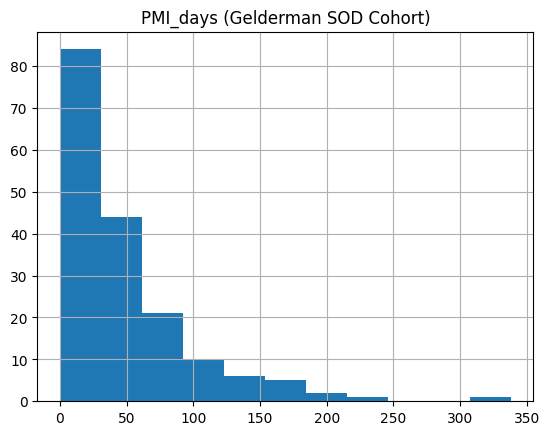

In [69]:
unique_triplets.hist(column='PMI_days', bins=11)
plt.title('PMI_days (Gelderman SOD Cohort)')
plt.show()

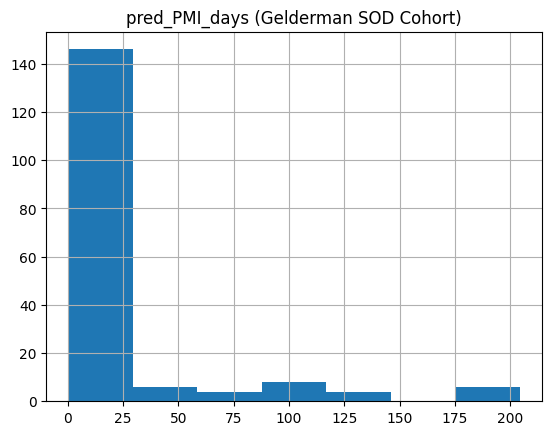

In [70]:
unique_triplets.hist(column='pred_PMI_days', bins=7)
plt.title('pred_PMI_days (Gelderman SOD Cohort)')
plt.show()

In [20]:
custom_bins = [0,1,2,3,4,5,6,7,8,9,10,  #1
12,14,16,18,20,  #2
23,26,29,32,  #3
36,40,  #4
45,50,  #5
56,61,
68,
76,
85,
95, #10              
106,
118,
131,
145,
160, #15
176,
193,               
211,
230,
250, #20
271,
293,              
316,               
340,
365]

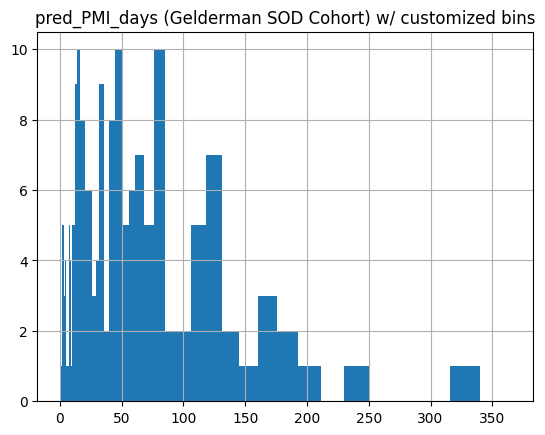

In [71]:
# PMI_days histogram with customized bin widths. 
unique_triplets.hist(column='PMI_days', bins=custom_bins)
plt.title('pred_PMI_days (Gelderman SOD Cohort) w/ customized bins')
plt.show()

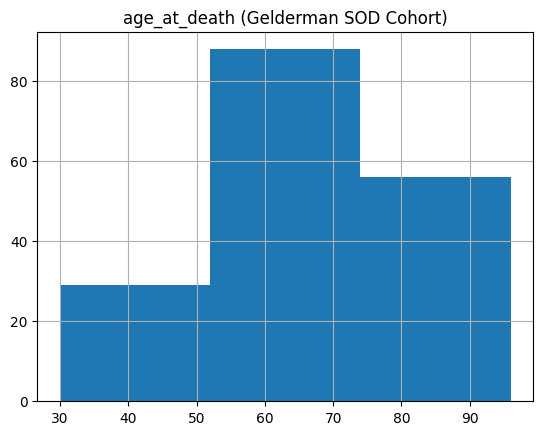

In [72]:
unique_triplets.hist(column='age_at_death', bins=3)
plt.title('age_at_death (Gelderman SOD Cohort)')
plt.show()

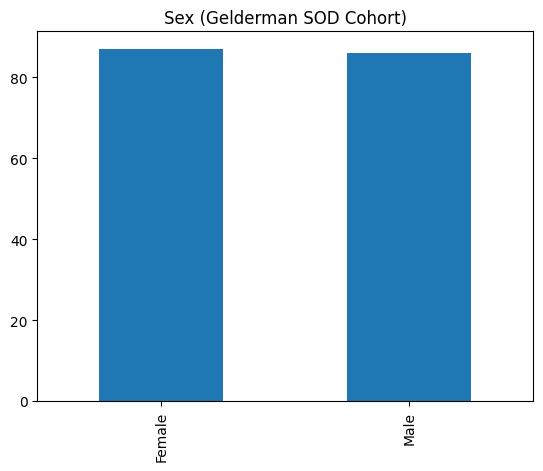

In [73]:
unique_triplets['sex'].value_counts().plot(kind='bar')
plt.title('Sex (Gelderman SOD Cohort)')
plt.show()

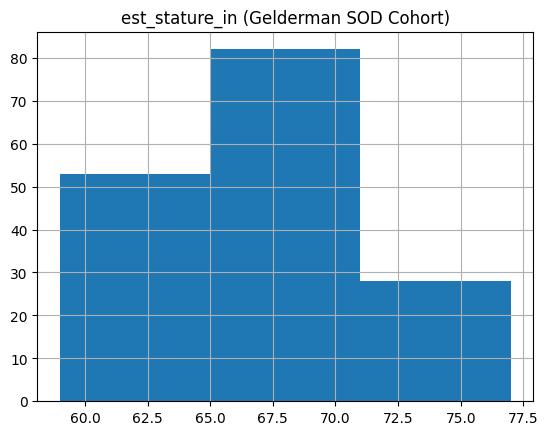

In [74]:
unique_triplets[unique_triplets.est_stature_in > 50].hist(column='est_stature_in', bins=3)
plt.title('est_stature_in (Gelderman SOD Cohort)')
plt.show()

In [75]:
# BMI distribution (CDC BMI categories: underweight, healthy, overweight, obese)
# https://www.cdc.gov/healthyweight/assessing/index.html#:~:text=If%20your%20BMI%20is%20less,falls%20within%20the%20obese%20range.
def bmi_imperial(weight_lb, height_in):
    if height_in != 0: 
        bmi = round(703*(weight_lb/(height_in**2)), 1)
    else:
        bmi = np.nan
    return bmi

def bmi_status(bmi):
    if bmi < 18.5:
        status = 'underweight'
    elif 18.5 <= bmi <= 24.9:
        status = 'healthy'
    elif 24.9 < bmi <= 29.9:
        status = 'overweight'
    elif bmi > 29.9:
        status = 'obese'
    elif pd.isna(bmi):
        status = float('nan')
    return status

unique_triplets['BMI'] = unique_triplets.apply(lambda x: bmi_imperial(x['est_weight_lb'], x['est_stature_in'])
                                               , axis=1)
unique_triplets['BMI_status'] = unique_triplets.apply(lambda x: bmi_status(x['BMI']), axis=1)
display(unique_triplets.head())

,new_id,img_head,correct_img_date,date_placed_ARF,PMI_days,age_at_death,sex,est_weight_lb,est_stature_in,true_SOD_G_head,BP_of_true_SOD_G,donor_date,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs,TDS,pred_PMI_days,BMI,BMI_status
0,004,00400124.12.JPG,2018-01-24,2018-01-09,15.0,77.0,Female,180.0,64.000000,3.0,head,00400124,00400124.07.JPG,3.0,00400124.10.JPG,3.0,9.0,4.897788,30.9,obese
300,006,00600212.07.JPG,2018-02-12,2018-01-09,34.0,81.0,Male,NaN,NaN,3.0,head,00600212,00600212.25.JPG,3.0,00600212.06.JPG,3.0,9.0,4.897788,NaN,NaN
327,00b,00b00525.08.JPG,2016-05-25,2016-03-07,79.0,38.0,Male,516.0,73.000039,5.0,head,00b00525,00b00525.04.JPG,5.0,00b00525.27.JPG,3.0,13.0,25.703958,68.1,obese
351,00b,00b00818.07.JPG,2016-08-18,2016-03-07,164.0,38.0,Male,516.0,73.000039,6.0,head,00b00818,00b00818.05.JPG,6.0,00b00818.11.JPG,3.0,15.0,58.884366,68.1,obese
355,00d,00d10116.07.JPG,2019-01-16,2018-11-27,50.0,73.0,Male,235.0,73.000039,5.0,head,00d10116,00d10116.04.JPG,4.0,00d10116.06.JPG,4.0,13.0,25.703958,31.0,obese


In [76]:
unique_triplets.sample(3)

,new_id,img_head,correct_img_date,date_placed_ARF,PMI_days,age_at_death,sex,est_weight_lb,est_stature_in,true_SOD_G_head,BP_of_true_SOD_G,donor_date,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs,TDS,pred_PMI_days,BMI,BMI_status
10590,18c,18c00330.14.JPG,2022-03-30,2022-03-24,6.0,92.0,Male,210.0,73.000039,3.0,head,18c00330,18c00330.09.JPG,2.0,18c00330.03.JPG,3.0,8.0,3.235937,27.7,overweight
33988,b60,b6000713.07.JPG,2017-07-13,2017-06-27,16.0,94.0,Male,183.0,72.000039,4.0,head,b6000713,b6000713.11.JPG,4.0,b6000713.06.JPG,5.0,13.0,25.703958,24.8,healthy
28781,9f4,9f400324.27.JPG,2013-03-24,2013-03-20,4.0,30.0,Female,200.0,73.000039,2.0,head,9f400324,9f400324.06.JPG,2.0,9f400324.10.JPG,2.0,6.0,1.412538,26.4,overweight


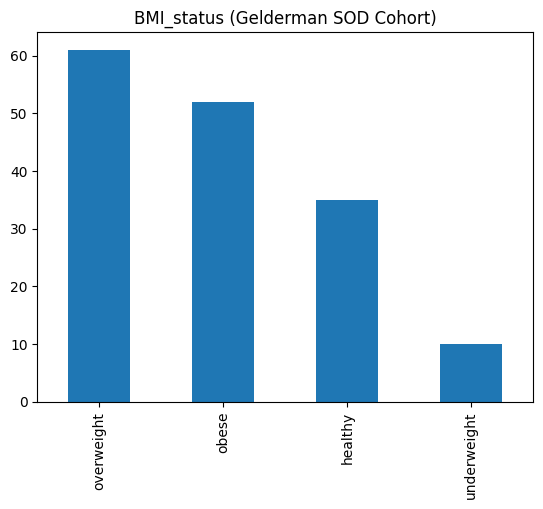

In [77]:
unique_triplets['BMI_status'].value_counts().plot(kind='bar')
plt.title('BMI_status (Gelderman SOD Cohort)')
plt.show()

In [78]:
# create season_of_recovery
unique_triplets['month'] = unique_triplets['donor_date'].str[-4:-2]
print(unique_triplets.month.unique())

winter = ['12', '01', '02']
spring = ['03', '04', '05']
summer = ['06', '07', '08']
fall = ['09', '10', '11']


conditions = [
    (unique_triplets['month'].isin(winter)),
    (unique_triplets['month'].isin(spring)),
    (unique_triplets['month'].isin(summer)),
    (unique_triplets['month'].isin(fall))
    ]

values = ['winter', 'spring', 'summer', 'fall']

unique_triplets['season_of_recovery'] = np.select(conditions, values)

['01' '02' '05' '08' '12' '04' '03' '07' '06' '09' '11' '10']


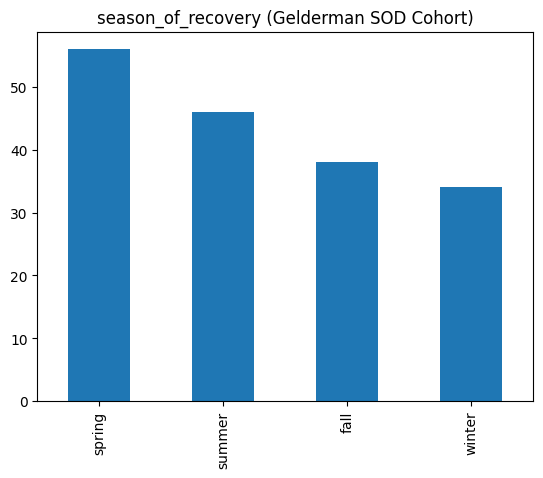

In [79]:
unique_triplets['season_of_recovery'].value_counts().plot(kind='bar')
plt.title('season_of_recovery (Gelderman SOD Cohort)')
plt.show()

Based on the above histograms, need more samples for larger PMI bins while focusing on donors with 
* age < 50
* weight = obese, healthy, underweight

The sampling will be done in sample_for_additional_labeling.ipynb.